# Importation des packages

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import (precision_recall_curve, classification_report, roc_curve,
                             confusion_matrix, make_scorer, matthews_corrcoef)
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
import time

import pymysql.cursors
sns.set_style('darkgrid')

# Initialisation

In [3]:
# Copie du dataframe, pour éviter d'avoir à recompiler la cellule précédente
df = dataframe.copy()

# Selection des variables explicatives :

dep = []
nb = [] 
for word in df.columns :
    if word.startswith("SOINS_seac_") :
        nb.append(word)
    elif word.startswith("SOINS_dep") :
        dep.append(word)
        
esps = ['PERSONNE_sexe', 'PERSONNE_age', 'PERSONNE_couple',
        'PERSONNE_etatleg','PERSONNE_statut','PERSONNE_ss',
        'PERSONNE_regime','MENAGE_rap_typmen','MUTUELLE_assu',
        'MENAGE_tu','MENAGE_rap_zau','MENAGE_revenu',
        'MENAGE_region','PERSONNE_rap_pcs8','PERSONNE_pb_depress']              

features = esps + dep + nb 
df = df[features]

to_delete = []
for word in df.columns : 
    if word.endswith('aau') or word.endswith('aux') or word.endswith('amb') or word.endswith(
        'med') or word.endswith('spe') or word.endswith('pra') or word.endswith('psd') :
        to_delete.append(word)       
df.drop(to_delete, inplace=True, axis=1)

# Conversion des types des variables la base en numérique (initialement de type objet).
df.replace("", np.nan, inplace=True)
cols = df.columns
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Suppression des non réponses de la variable cible (apprentissage supervisé)
df = df[np.isfinite(df['PERSONNE_pb_depress'])]
df['PERSONNE_pb_depress'] = df['PERSONNE_pb_depress'].map({2:0,1:1})
print("Dimension du jeu de données sans les moins de 15 ans: {}".format(df.shape))
print("Proportion de 1: {0:.1%}".format(df.PERSONNE_pb_depress.mean()))

#Renommage des variables :
df.columns = ['sexe', 'age', 'couple','etatleg','statut', 'ss','regime','rap_typmen', 'assu',
              'tu', 'rap_zau','revenu','region','rap_pcs8','pb_depress',
              'depana', 'depane', 'depbio','depcar', 'depchig', 'depchii', 'depchim',
              'depchims', 'depchio', 'depchip', 'depchitc','depchiu', 'depchiv', 'depchivd', 'depden',
              'depder', 'depend', 'depgas', 'depgene','depger', 'depgynm', 'depgyno', 'depgynom',
              'dephem', 'depinf', 'depkin', 'depmat','depmedi', 'depmedn', 'depmedpr', 'depnep',
              'depneu', 'depneuc', 'depneup', 'depobs','depomn', 'deponcm', 'deponcr', 'depoph',
              'depopt', 'deporl', 'deporthop', 'deporthot','depped', 'deppedia', 'deppha', 'deppne',
              'deppro', 'deppsye', 'deppsyg', 'depradd','depradt', 'deprhu', 'depsag', 'depsantp',
              'depsoin_e', 'depspeinc', 'depsto', 'deptra','depurg', 'seac_ane', 'seac_aut', 'seac_car',
              'seac_chi', 'seac_der', 'seac_end', 'seac_gas','seac_gyn', 'seac_neu', 'seac_omn', 'seac_oph',
              'seac_orl', 'seac_ped', 'seac_psy', 'seac_rad','seac_rhu']

# Aperçu des valeurs manquantes :
def missing_values_table(df) :
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending = False).round(1)
        print ("\nYour selected dataframe has " + str(df.shape[1]) + " columns.\nThere are " +
               str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.\n")
        return mis_val_table_ren_columns
print(missing_values_table(df))


# Stockage des variables catégorielles/ordinales dans une liste, et des variables continues dans une autre liste
categorical_variables = [c for c in list(df)[:14] if c not in ['age']]
numerical_variables = [x for x in df.columns if x not in categorical_variables + ['pb_depress']]

Dimension du jeu de données sans les moins de 15 ans: (6917, 91)
Proportion de 1: 6.3%

Your selected dataframe has 91 columns.
There are 9 columns that have missing values.

          Missing Values  % of Total Values
couple              1263               18.3
assu                 915               13.2
statut               706               10.2
etatleg               91                1.3
revenu                51                0.7
rap_pcs8               5                0.1
regime                 2                0.0
tu                     1                0.0
rap_zau                1                0.0


# Preprocessing

Le one-hot encoding est un cas particulier : de manière à éviter une différence de nombre de colonnes entre le jeu d'entraînement et le jeu de test (certaines modalités dans le jeu d'entraînement n'apparaissant pas dans le jeu de test), l'encodage est effectué sur le jeu de données initial, puis nous séparons ensuite le jeu de données en 2 sous jeux (entraînement/test).

In [5]:
def one_hot_encoding(dataset) :
    '''OHE des variables categorielles'''
    cat_dataset = pd.DataFrame()
    cat_dataset = pd.get_dummies(dataset[categorical_variables], dummy_na=False, columns=categorical_variables)
    complete_dataset = pd.concat([cat_dataset, dataset[numerical_variables], dataset['pb_depress']], axis=1)
    return complete_dataset

def log_transform(dataset) :
    '''log transformation des variables de santé (dépenses + nombre de séances)'''
    health_variables = [h for h in numerical_variables if h not in ['age']]
    for c in health_variables :
        dataset[c+"_log"] = np.log1p(dataset[c])
    dataset.drop(health_variables,inplace=True,axis=1)
    return dataset 

df_train_ohe, df_test_ohe = train_test_split(log_transform(one_hot_encoding(df)), test_size=0.2, random_state=0)
X_train_ohe = df_train_ohe.drop('pb_depress',axis=1)
X_test_ohe = df_test_ohe.drop('pb_depress',axis=1)
y_train_ohe = df_train_ohe['pb_depress']
y_test_ohe = df_test_ohe['pb_depress']

Pour les autres cas de figure, nous faisons __d'abord la séparation du jeu de données en 2 sous jeux__ (entraînement/test), puis nous appliquons les transformations sur les 2 jeux de données séparément. 

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=0)

# Imputation par la valeur la plus fréquente (à remplacer par le MissForest d'ailleurs !) 
df_train = df_train.fillna(df_train.mode().iloc[0])
df_test = df_test.fillna(df_test.mode().iloc[0])

##################################### Frequency encoding #########################################

train_freq = df_train.copy()
test_freq = df_test.copy()

def get_freq_encoding(dataset, train_file):
    '''
       Fonction permettant d'appliquer l'encodage en fréquence sur le jeu d'entraînement.
       Les nouvelles modalités calculées sur le jeu d'entraînement seront ensuite appliquées au jeu de test.
       Permet d'éviter le phénomène de "data leakage" du jeu de test.
    '''
    new_dataset = pd.DataFrame()
    for c in categorical_variables :
        data = train_file.groupby([c]).size()/len(train_file)
        new_dataset[c+"_freq"] = dataset[c].map(data)
    return new_dataset

def get_log_transform(dataset):
    '''log transformation des variables de santé (dépenses + nombre de séances)'''
    new_dataset = pd.DataFrame()
    health_variables = [h for h in numerical_variables if h not in ['age']]
    for c in health_variables :
        new_dataset[c+"_log"] = np.log1p(dataset[c])
    return new_dataset

X_train_freq = pd.concat([get_freq_encoding(train_freq,train_freq), get_log_transform(train_freq)], axis=1)
X_test_freq = pd.concat([get_freq_encoding(test_freq,train_freq), get_log_transform(test_freq)], axis=1)
y_train_freq = train_freq['pb_depress']
y_test_freq = test_freq['pb_depress']

##################################### Additive target mean encoding #####################################

train_addi = df_train.copy()
test_addi = df_test.copy()

def get_additive_encoding(train_set, train_or_test_set, m = 300) 
    '''
       Fonction permettant d'appliquer l'encodage additif sur le jeu d'entraînement.
       Les nouvelles modalités calculées sur le jeu d'entraînement seront ensuite appliquées au jeu de test.
       Permet d'éviter le phénomène de "data leakage" du jeu de test.
    '''
    new_dataset = pd.DataFrame()
    mean = train_set['pb_depress'].mean()
    for c in categorical_variables :
        agg = train_set.groupby(c)['pb_depress'].agg(['count','mean'])
        counts = agg["count"]
        means = agg["mean"]
        smooth = (counts * means + m * mean) / (counts + m)
        new_dataset[c+"_add"] = train_or_test_set[c].map(smooth) 
    return new_dataset

X_train_addi = pd.concat([get_additive_encoding(train_addi,train_addi),get_log_transform(train_addi)],axis=1)
X_test_addi = pd.concat([get_additive_encoding(train_addi,test_addi),get_log_transform(test_addi)],axis=1)
y_train_addi = train_addi['pb_depress']
y_test_addi = test_addi['pb_depress']

## Frequency & additive target mean encoding

### Frequency Encoding

Cette technique consiste à transformer les modalités de la variable explicative en valeurs comprise entre 0 et 1 correspondant à leurs fréquences relatives (pouvant être vu comme la probabilité de rencontrer cette modalité dans notre jeu de données). 

Soit $frequency_{m}$ la nouvelle valeur prise prise par une variable explicative pour la modalité $m$ telle que :

\begin{equation}
\displaystyle frequency_{m} = \frac{n_{m}}{N}
\end{equation}

Avec $n_{m}$ le nombre d'observations de la variable explicative ayant la modalité $m$, et $N$ le nombre total d'observation.

__Exemple :__ Une variable explicative prenant 3 modalités différentes : __a, b, c__.

| __Variable explicative__ | 
| ------------- |
| a   |
| a   |
| a   | 
| a   |
| b   | 
| b   |
| b   |
| c   |    


On aura donc comme __nouvelles modalités de la variable explicative__ : 

$$
\left\{
\begin{array}{r c l}
frequency_{a} = \frac{n_{a}}{N} = \frac{4}{9} = 0.44\\
frequency_{b} = \frac{n_{b}}{N} = \frac{3}{9} = 0.33\\
frequency_{c} = \frac{n_{c}}{N} = \frac{2}{9} = 0.22
\end{array}
\right.
$$

### Additive target mean encoding

\begin{equation}
\displaystyle additive_{m} = \frac{p_{m} n_{m} + p_{global} \alpha}{n_{m} + \alpha}
\end{equation}

Avec $n_{m}$ le nombre d’observations ayant la modalité $m$, $p_{m}$ la proportion de 1 conditionnelle à la
modalité $m$, $p_{global}$ la proportion de 1 pour l’ensemble du jeu de données, $\alpha$ le « poids » que nous
souhaitons assigner à la proportion de 1 pour l’ensemble du jeu de données.

Dans cette approche, le seul paramètre à fixer est $\alpha$. L’idée est la suivante : plus $\alpha$ est grand, plus nous accorderons de l’importance à la proportion de 1 pour l’ensemble du jeu de données, $p_{global}$ .
Si $\alpha$ est égal à 0, alors aucun lissage n’interviendra.

## Choix de la méthode (mettre les autres en commentaire)

In [7]:
#X_train, X_test, y_train, y_test = X_train_ohe.copy(), X_test_ohe.copy(), y_train_ohe.copy(), y_test_ohe.copy()
#X_train, X_test, y_train, y_test = X_train_freq.copy(), X_test_freq.copy(), y_train_freq.copy(), y_test_freq.copy()
X_train, X_test, y_train, y_test = X_train_addi.copy(), X_test_addi.copy(), y_train_addi.copy(), y_test_addi.copy()

In [15]:
# Quelques fonctions utiles

def random_forest(weights=None) :
    '''Random forest (weighted or not)'''
    rf = RandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1, random_state=0, class_weight=weights)
    return rf

def resampled_random_forest() :
    '''Balanced random forest'''
    resampled_rf = BalancedRandomForestClassifier(n_estimators=300, max_depth=6, n_jobs=-1, random_state=0)
    return resampled_rf

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    '''Fonction permettant afficher la courbe précision/rappel VS seuil de décision'''
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(thresholds, precisions[:-1], "b-", label = "Précision")
    plt.plot(thresholds, recalls[:-1], "g-", label = "Rappel")
    plt.xlabel("Seuil", fontsize = 16)
    plt.ylabel("Précision, Rappel",fontsize=16)
    plt.title("Courbe précision-rappel VS seuil",fontsize=20)
    plt.legend(fontsize = 12)
    plt.ylim([0,1])
    plt.show()

def get_aucpr(y_true,y_pred) :
    '''Fonction permettant obtenir l'aire sous la courbe précision/rappel'''
    precision, recall, th = precision_recall_curve(y_true, y_pred)
    aucpr = -np.trapz(precision,recall)
    return aucpr
    
def plot_precision_recall_curve(r,p,y_true,y_pred) :
    '''Fonction pour afficher la courbe précision rappel, avec l'aire sous celle-ci'''
    plt.figure(figsize=(12,5))
    plt.plot(r,p,label = "AUCPR = %0.2f" % get_aucpr(y_true,y_pred))
    plt.xlabel('Rappel', fontsize=16)
    plt.ylabel("Précision", fontsize=16)
    plt.title("Courbe Précision Rappel", fontsize=20)
    plt.legend(fontsize=12)
    plt.show()
    
def plot_roc_curve(fpr,tpr,roc_auc) :
    '''Fonction pour afficher la courbe ROC, avec l'aire sous celle-ci'''
    plt.figure(figsize=(12,5))
    plt.title('Courbe ROC', fontsize = 20)
    plt.plot(fpr, tpr, label = 'Random Forest : AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right', fontsize = 12)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('Taux de vrais positifs\n(sensibilité)', fontsize = 16)
    plt.xlabel('Taux de faux positifs (1 - spécificité)', fontsize = 16)
    plt.show()
    

# 2 métriques intéressantes à optimiser en cas de classes déséquilibrés : le MCC, et l'AUCPR.
mcc = make_scorer(matthews_corrcoef, greater_is_better=True)
aucpr = make_scorer(get_aucpr, greater_is_better=True)
dict_of_metrics = {'roc_auc':'roc_auc',
                   'average_precision':'average_precision',
                   'mcc':mcc, 
                   'aucpr':aucpr}

def cross_validate_results(pipeline):
    '''Fonction permettant de réaliser une validation croisée à 5 passes à partir d'un pipeline,
    permettant d'obtenir un dataframe de résultats aussi bien sur le jeu d'entraînement que sur
    les jeux de validation.
    '''
    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring = dict_of_metrics,
                            n_jobs=-1, return_train_score=True)
    scores = pd.DataFrame(scores)
    results = scores.describe().transpose()
    return results

def plot_confusion_matrix(cm, put_title):
    '''Fonction permettant d'afficher la matrice de confusion'''
    plt.figure(figsize = (11,6))
    sns.heatmap(cm, annot=True, fmt='2.0f', annot_kws={"size": 16}, cmap="PuBu")
    plt.ylabel('Classe réelle',fontsize=18)
    plt.xlabel('Classe prédite',fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(put_title, fontsize=24)
    plt.show()

In [16]:
# Premier essai sur le jeu de test
rf = random_forest()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print("Random forest, default threshold:\n\n{}".format(classification_report(y_test,y_pred)))
y_pred = rf.predict_proba(X_test)[:,1] > .06
print("Random forest, changing threshold:\n\n{}".format(classification_report(y_test,y_pred)))

/home/quentin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/quentin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/quentin/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Random forest, default threshold:

              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1291
           1       0.00      0.00      0.00        93

   micro avg       0.93      0.93      0.93      1384
   macro avg       0.47      0.50      0.48      1384
weighted avg       0.87      0.93      0.90      1384

Random forest, changing threshold:

              precision    recall  f1-score   support

           0       0.97      0.72      0.83      1291
           1       0.16      0.72      0.26        93

   micro avg       0.72      0.72      0.72      1384
   macro avg       0.56      0.72      0.54      1384
weighted avg       0.92      0.72      0.79      1384



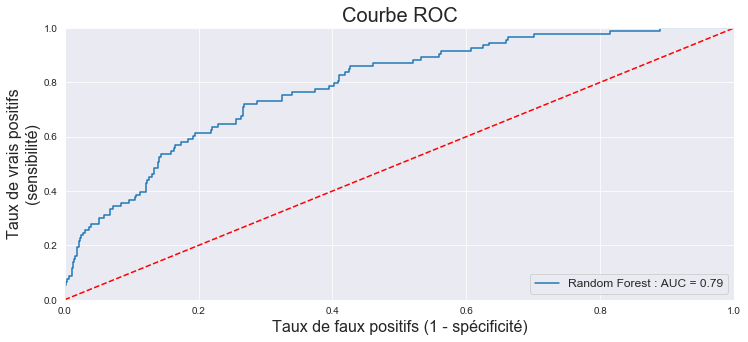

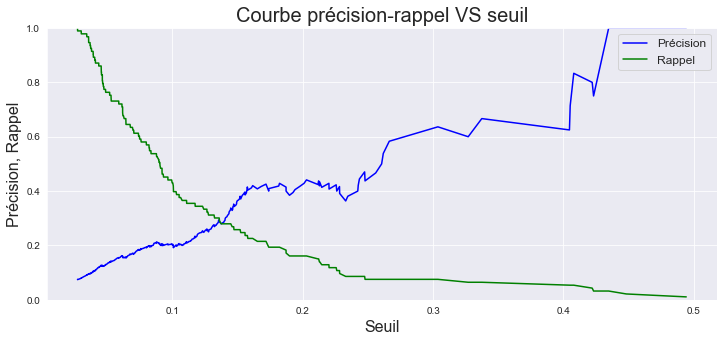

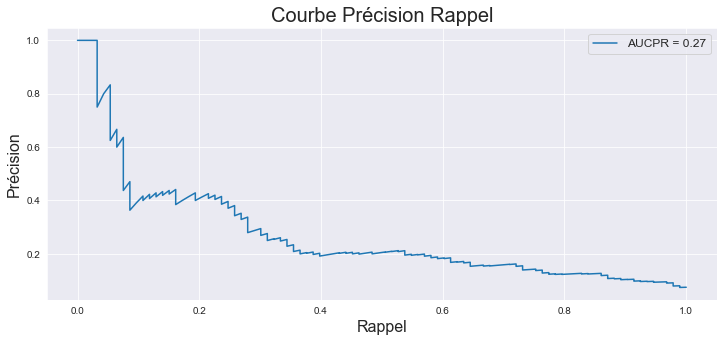

In [17]:
rf.fit(X_train,y_train)
y_pred = rf.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
plot_roc_curve(fpr,tpr,metrics.auc(fpr,tpr))
plot_precision_recall_vs_threshold(precision, recall, thresholds)
plot_precision_recall_curve(r = recall, p = precision, y_true = y_test, y_pred = y_pred)

## Random Undersampling

In [23]:
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train,y_train)
print("X train shape: {}\nX train subsample shape: {}".format(X_train.shape,X_train_subsample.shape))
print("Number of 0, Number of 1: ", np.bincount(y_train_subsample.astype(int)))

undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(random_state=0),random_forest())
cross_validate_results(undersample_pipe_rf)

X train shape: (5533, 89)
X train subsample shape: (686, 89)
Number of 0, Number of 1:  [343 343]


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,0.454311,0.048920,0.366952,0.471642,0.475680,0.478320,0.478959
score_time,5.0,0.669531,0.386520,0.430138,0.512951,0.522821,0.524347,1.357399
test_roc_auc,5.0,0.768878,0.026116,0.743221,0.750244,0.762280,0.780460,0.808186
train_roc_auc,5.0,0.861597,0.003406,0.857472,0.860509,0.861256,0.861859,0.866891
test_average_precision,5.0,0.234060,0.026874,0.193395,0.227922,0.235824,0.247092,0.266070
train_average_precision,5.0,0.442243,0.012797,0.428469,0.431362,0.440945,0.453163,0.457274
test_mcc,5.0,0.210175,0.020364,0.189615,0.198478,0.199570,0.225769,0.237445
train_mcc,5.0,0.283279,0.007165,0.276416,0.277940,0.281338,0.286748,0.293954
test_aucpr,5.0,0.428506,0.025047,0.405109,0.414030,0.416528,0.439898,0.466966
train_aucpr,5.0,0.502342,0.011008,0.490408,0.494752,0.498663,0.512940,0.514945


{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 300}


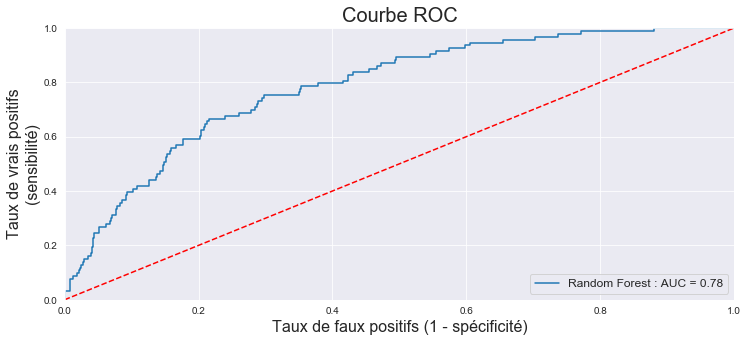

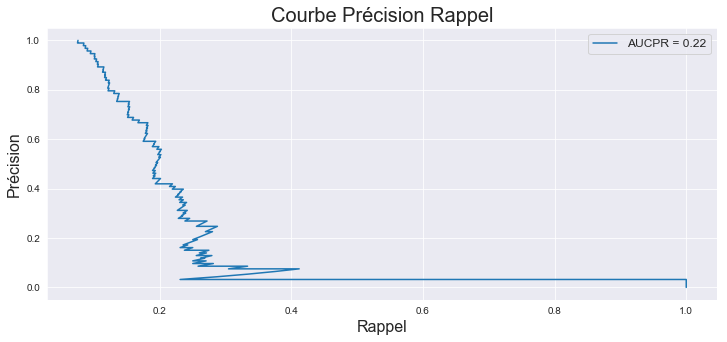

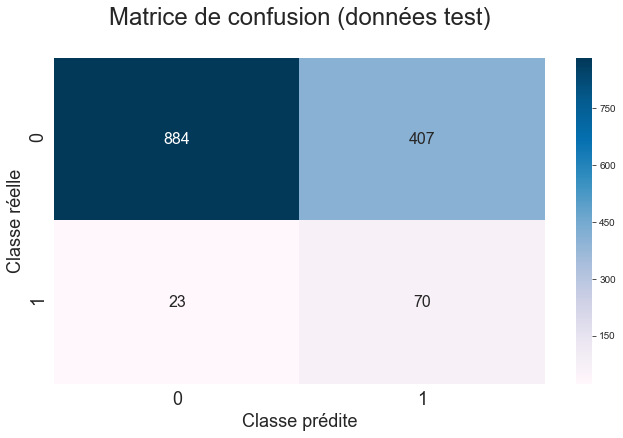

              precision    recall  f1-score   support

           0       0.97      0.68      0.80      1291
           1       0.15      0.75      0.25        93

   micro avg       0.69      0.69      0.69      1384
   macro avg       0.56      0.72      0.52      1384
weighted avg       0.92      0.69      0.77      1384



In [24]:
param_grid = {'randomforestclassifier__n_estimators': [300,350,400],
              'randomforestclassifier__max_depth': [3,4,5,6]}

search = GridSearchCV(undersample_pipe_rf, param_grid, cv = 5, scoring = aucpr, n_jobs = 3)
search.fit(X_train, y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall, y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")
print(classification_report(y_test, y_pred))

## Random Oversampling

In [25]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train,y_train)
print("X train shape: {}\nX train oversample shape: {}".format(X_train.shape, X_train_oversample.shape))
print("Number of 0, Number of 1: ", np.bincount(y_train_oversample.astype(int)))

oversample_pipe_rf = make_imb_pipeline(RandomOverSampler(random_state=0),random_forest())
cross_validate_results(oversample_pipe_rf)

X train shape: (5533, 89)
X train oversample shape: (10380, 89)
Number of 0, Number of 1:  [5190 5190]


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.306346,0.812101,1.164857,1.722498,2.847311,2.889997,2.907068
score_time,5.0,0.870753,0.175040,0.739997,0.769628,0.833615,0.835455,1.175068
test_roc_auc,5.0,0.773835,0.017902,0.761121,0.761470,0.769636,0.772333,0.804616
train_roc_auc,5.0,0.906165,0.003060,0.902521,0.903353,0.907148,0.908482,0.909319
test_average_precision,5.0,0.240330,0.008165,0.230309,0.232717,0.244488,0.246722,0.247414
train_average_precision,5.0,0.614596,0.010835,0.605926,0.607691,0.611317,0.615126,0.632919
test_mcc,5.0,0.215382,0.015945,0.193003,0.213763,0.215195,0.216961,0.237986
train_mcc,5.0,0.383704,0.007136,0.373098,0.381501,0.383592,0.388959,0.391368
test_aucpr,5.0,0.373164,0.015638,0.354346,0.365217,0.370909,0.379467,0.395883
train_aucpr,5.0,0.535866,0.002814,0.531324,0.535097,0.536997,0.537484,0.538427


{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 400}


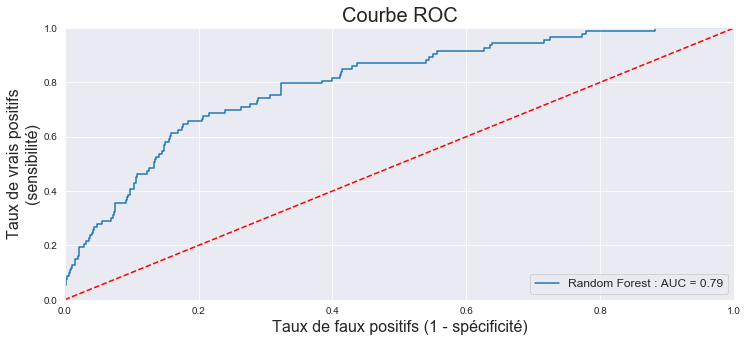

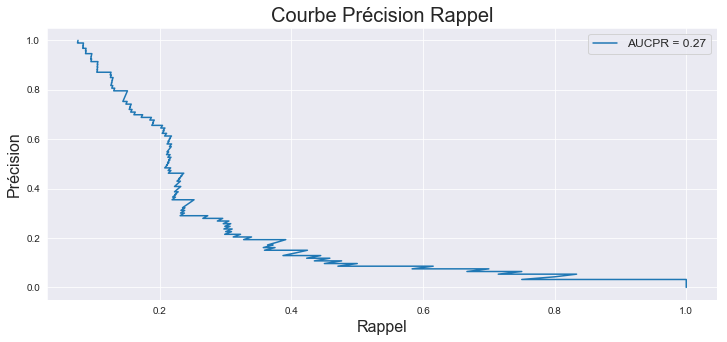

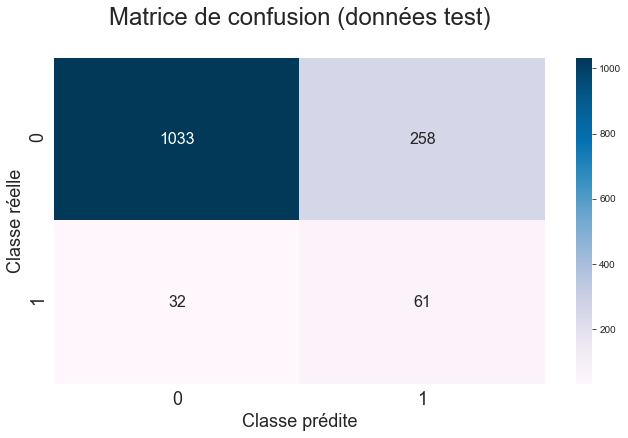

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      1291
           1       0.19      0.66      0.30        93

   micro avg       0.79      0.79      0.79      1384
   macro avg       0.58      0.73      0.59      1384
weighted avg       0.92      0.79      0.84      1384



In [27]:
search = GridSearchCV(oversample_pipe_rf, param_grid, cv=5, scoring=mcc, n_jobs=3)
search.fit(X_train,y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall,y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")
print(classification_report(y_test, y_pred))

## Class-weights

- Instead of repeating samples, re-weight the loss function
- Works for most models
- Same effect as over-sampling (though not random), but nos as expensive (dataset size the same)

In [28]:
cross_validate_results(random_forest(weights='balanced'))

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,1.833059,0.617802,0.894999,1.506361,2.201119,2.245869,2.316947
score_time,5.0,0.763578,0.116619,0.627317,0.732559,0.744542,0.764131,0.949341
test_roc_auc,5.0,0.774289,0.017091,0.761540,0.764267,0.768940,0.772835,0.803865
train_roc_auc,5.0,0.901718,0.003672,0.895857,0.900992,0.902789,0.903309,0.905640
test_average_precision,5.0,0.225573,0.013749,0.209395,0.212211,0.231394,0.236890,0.237977
train_average_precision,5.0,0.580698,0.009280,0.574668,0.576210,0.576786,0.578732,0.597093
test_mcc,5.0,0.232000,0.032832,0.190754,0.208242,0.240116,0.246987,0.273900
train_mcc,5.0,0.416425,0.007787,0.408979,0.411153,0.412300,0.424378,0.425315
test_aucpr,5.0,0.355028,0.032609,0.321760,0.325397,0.361023,0.365962,0.400998
train_aucpr,5.0,0.527596,0.004578,0.521051,0.526023,0.527323,0.530521,0.533062


{'max_depth': 6, 'n_estimators': 400}


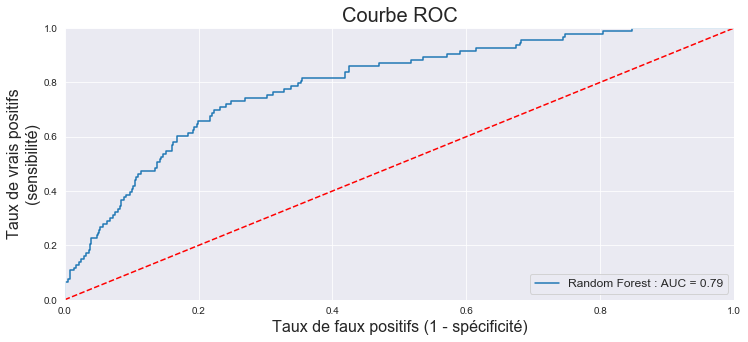

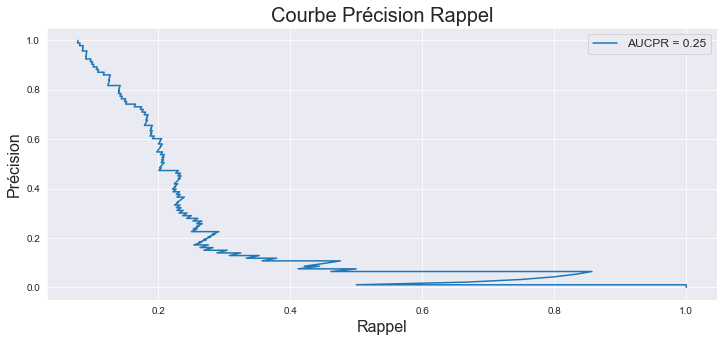

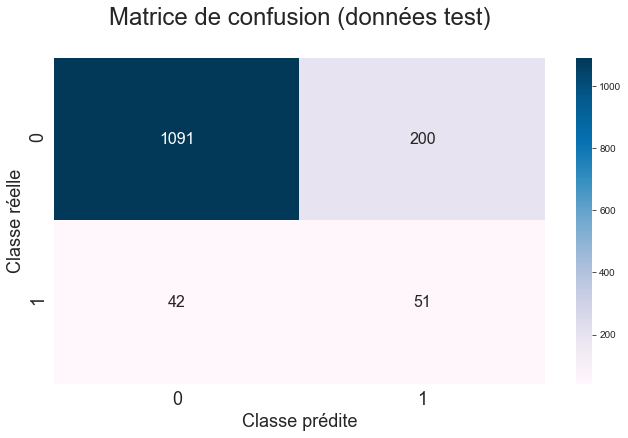

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      1291
           1       0.20      0.55      0.30        93

   micro avg       0.83      0.83      0.83      1384
   macro avg       0.58      0.70      0.60      1384
weighted avg       0.91      0.83      0.86      1384



In [29]:
param_grid = {'n_estimators':[300,350,400], 'max_depth':[3,4,5,6]}
search = GridSearchCV(random_forest(weights="balanced"), param_grid, cv=5, scoring=mcc, n_jobs=3)
search.fit(X_train,y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall,y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")

print(classification_report(y_test, y_pred))

## Ensemble Resampling

 - Random resampling separate for each instance in an ensemble
 - Chen, Liaw, Breiman: "Using random forest to learn imbalanced data".
 - Paper: "Exploratory Undersampling for Class Imbalance Learning"
 - Not in sklearn (yet)
 - Possible using imblearn

In [30]:
cross_validate_results(resampled_random_forest())

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,2.416529,0.557673,1.498158,2.399855,2.469781,2.791481,2.923368
score_time,5.0,0.847413,0.162310,0.625343,0.722324,0.950607,0.967552,0.971240
test_roc_auc,5.0,0.776537,0.022328,0.758817,0.760953,0.761917,0.794373,0.806628
train_roc_auc,5.0,0.858886,0.003992,0.852248,0.859409,0.859820,0.859878,0.863075
test_average_precision,5.0,0.238568,0.017164,0.215053,0.226200,0.245693,0.250933,0.254962
train_average_precision,5.0,0.469242,0.011399,0.453062,0.462838,0.471405,0.478081,0.480826
test_mcc,5.0,0.206309,0.023288,0.178274,0.184793,0.215135,0.224093,0.229250
train_mcc,5.0,0.273270,0.008100,0.261318,0.269051,0.275899,0.278768,0.281312
test_aucpr,5.0,0.429738,0.029871,0.392990,0.406735,0.433120,0.451234,0.464610
train_aucpr,5.0,0.497147,0.005034,0.488505,0.497860,0.498045,0.500097,0.501231


{'max_depth': 6, 'n_estimators': 350}


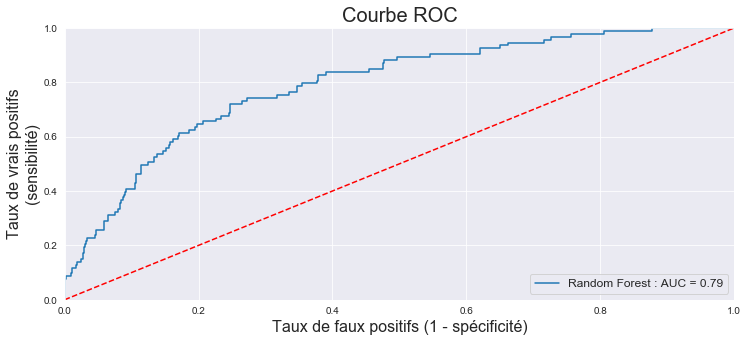

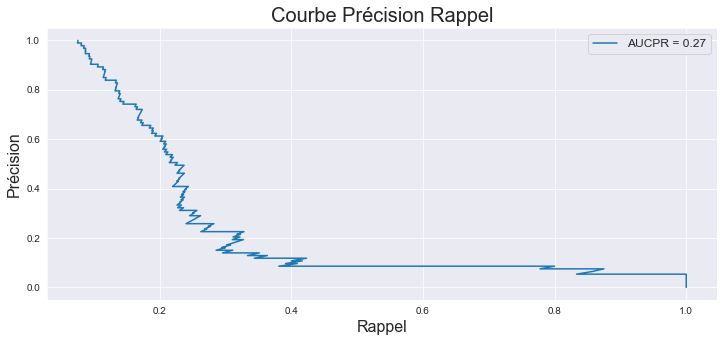

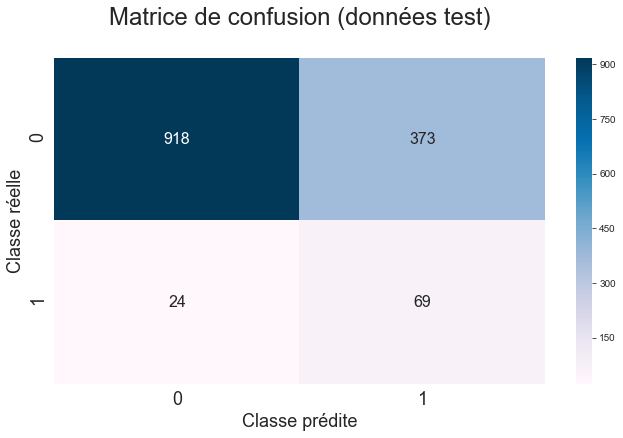

              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1291
           1       0.16      0.74      0.26        93

   micro avg       0.71      0.71      0.71      1384
   macro avg       0.57      0.73      0.54      1384
weighted avg       0.92      0.71      0.78      1384



In [31]:
param_grid = {'n_estimators':[300,350,400],
              'max_depth':[3,4,5,6]}

search = GridSearchCV(resampled_random_forest(), param_grid, cv=5, scoring=mcc, n_jobs=3)
search.fit(X_train,y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall,y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")

print(classification_report(y_test, y_pred))

## Edited Nearest Neighbours

In [32]:
from imblearn.under_sampling import EditedNearestNeighbours
enn_pipe_rf = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=10), random_forest())
cross_validate_results(enn_pipe_rf)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,6.957715,2.234712,3.090505,6.960705,8.119555,8.211110,8.406702
score_time,5.0,0.876166,0.150151,0.630207,0.883490,0.889038,0.944428,1.033668
test_roc_auc,5.0,0.760518,0.028070,0.738139,0.738432,0.746112,0.779398,0.800507
train_roc_auc,5.0,0.847782,0.006530,0.839746,0.842805,0.848058,0.854052,0.854248
test_average_precision,5.0,0.237937,0.024468,0.208466,0.231179,0.232307,0.241944,0.275790
train_average_precision,5.0,0.422312,0.006680,0.411651,0.420132,0.424757,0.427334,0.427684
test_mcc,5.0,0.203985,0.070823,0.119736,0.156624,0.191242,0.267760,0.284564
train_mcc,5.0,0.333212,0.018380,0.308408,0.321693,0.338811,0.341505,0.355644
test_aucpr,5.0,0.302313,0.073355,0.212198,0.259434,0.285948,0.368556,0.385429
train_aucpr,5.0,0.434433,0.017953,0.408858,0.423393,0.442069,0.444735,0.453111


{'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 450}


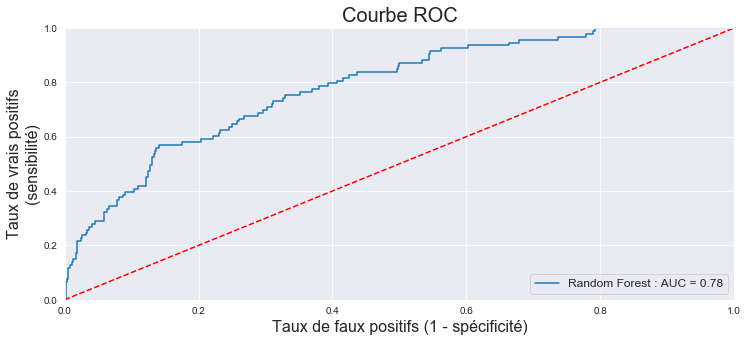

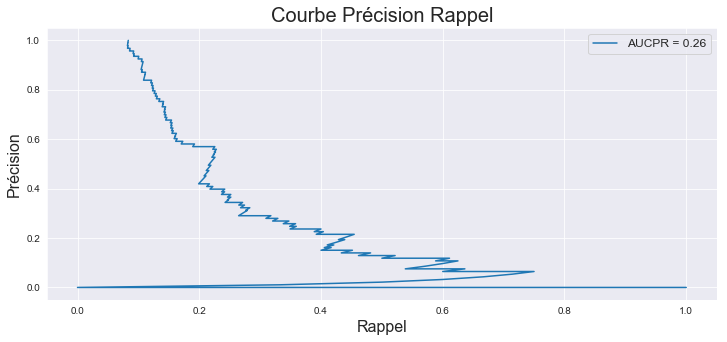

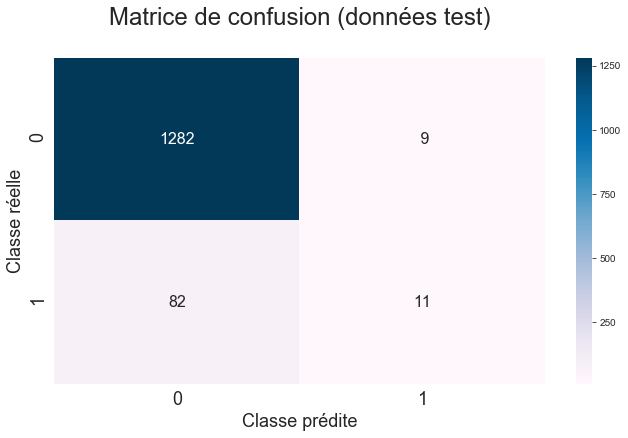

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1291
           1       0.55      0.12      0.19        93

   micro avg       0.93      0.93      0.93      1384
   macro avg       0.74      0.56      0.58      1384
weighted avg       0.91      0.93      0.91      1384



In [33]:
param_grid = {'randomforestclassifier__n_estimators': [300,350,400,450],
              'randomforestclassifier__max_depth': [3,4,5,6,7]}

search = GridSearchCV(enn_pipe_rf, param_grid, cv=5, scoring=mcc, n_jobs=3)
search.fit(X_train,y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall,y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")

print(classification_report(y_test, y_pred))

## Condensed Nearest Neighbours

__Warning :__ Long process.

In [34]:
%%time
from imblearn.under_sampling import CondensedNearestNeighbour
cnn = CondensedNearestNeighbour()
X_train_cnn, y_train_cnn = cnn.fit_sample(X_train,y_train)
print("X train cnn shape: {}".format(X_train_cnn.shape))
print(np.bincount(y_train_cnn.astype(int)))

X train cnn shape: (1360, 89)
[1017  343]
CPU times: user 7min 9s, sys: 0 ns, total: 7min 9s
Wall time: 7min 9s


In [35]:
%time
cnn_pipe_rf = make_imb_pipeline(CondensedNearestNeighbour(), random_forest())
cross_validate_results(cnn_pipe_rf)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,425.779759,101.984353,243.626884,461.979812,471.559060,475.804098,475.928941
score_time,5.0,0.670386,0.563644,0.415973,0.417238,0.419738,0.420321,1.678658
test_roc_auc,5.0,0.774134,0.029549,0.747787,0.750286,0.763690,0.792573,0.816332
train_roc_auc,5.0,0.876936,0.005492,0.870702,0.871545,0.878796,0.880929,0.882710
test_average_precision,5.0,0.247150,0.018783,0.218574,0.244970,0.248404,0.253152,0.270652
train_average_precision,5.0,0.521772,0.011032,0.511286,0.512587,0.520936,0.525644,0.538410
test_mcc,5.0,0.159273,0.064030,0.111406,0.133356,0.134610,0.145321,0.271671
train_mcc,5.0,0.426541,0.015003,0.410028,0.415820,0.423970,0.435876,0.447011
test_aucpr,5.0,0.281262,0.063137,0.238944,0.257447,0.258344,0.258345,0.393230
train_aucpr,5.0,0.551909,0.016464,0.524605,0.550118,0.556711,0.561097,0.567012


In [ ]:
param_grid = {'randomforestclassifier__n_estimators': [300,350,400,450],
              'randomforestclassifier__max_depth': [3,4,5,6,7]}

search = GridSearchCV(cnn_pipe_rf, param_grid, cv=5, scoring=mcc, n_jobs=3)
search.fit(X_train, y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall,y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")

print(classification_report(y_test, y_pred))

## Synthetic Minority Oversampling Technique (SMOTE)

- Adds synthetic interpolated data to smaller class
- For each sample in minority class:
    - Pick random neighbor from k neighbors
    - Pick point on line connecting the two uniformly (or within rectangle)
    - Repeat

In [37]:
from imblearn.over_sampling import SMOTE
smote_pipe_rf = make_imb_pipeline(SMOTE(random_state=0),random_forest())
cross_validate_results(smote_pipe_rf)

,count,mean,std,min,25%,50%,75%,max
fit_time,5.0,3.149972,0.996165,1.378580,3.414394,3.611133,3.640478,3.705278
score_time,5.0,0.806361,0.276941,0.548183,0.633809,0.738114,0.854346,1.257354
test_roc_auc,5.0,0.749588,0.008583,0.739689,0.742049,0.751641,0.754349,0.760215
train_roc_auc,5.0,0.852369,0.004421,0.846824,0.849912,0.851421,0.856372,0.857316
test_average_precision,5.0,0.171561,0.019919,0.145670,0.157580,0.173953,0.187728,0.192872
train_average_precision,5.0,0.334251,0.020696,0.315096,0.319390,0.326603,0.345103,0.365062
test_mcc,5.0,0.171655,0.046937,0.114857,0.127628,0.192549,0.208709,0.214533
train_mcc,5.0,0.312438,0.017205,0.297461,0.304558,0.305071,0.313646,0.341454
test_aucpr,5.0,0.275241,0.051629,0.208512,0.233908,0.291600,0.317307,0.324878
train_aucpr,5.0,0.404114,0.016684,0.392745,0.394930,0.395836,0.404114,0.432946


{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__n_estimators': 300}


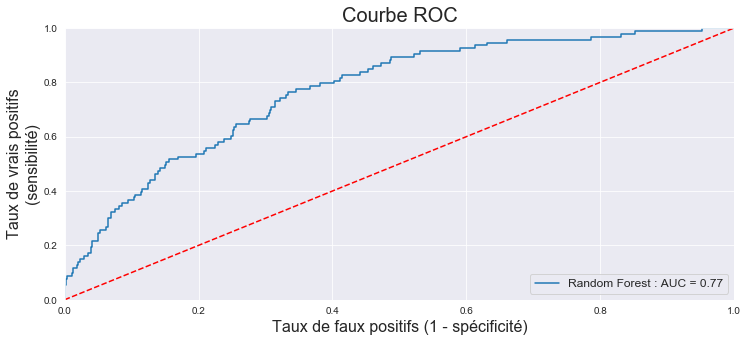

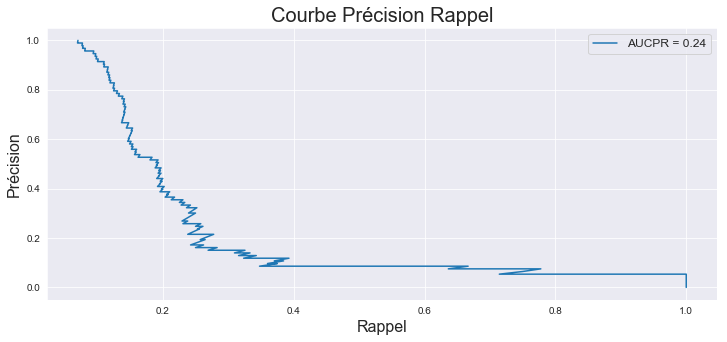

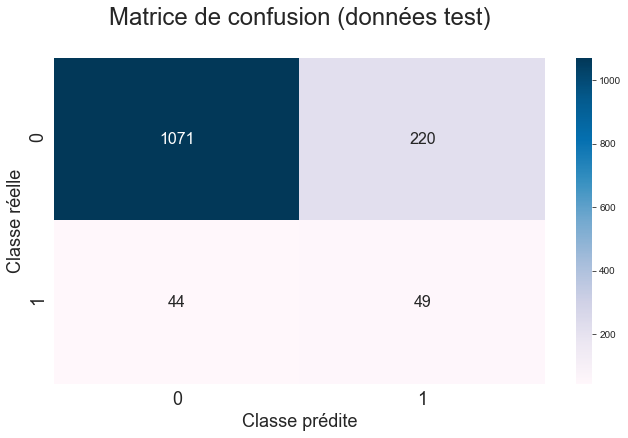

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1291
           1       0.18      0.53      0.27        93

   micro avg       0.81      0.81      0.81      1384
   macro avg       0.57      0.68      0.58      1384
weighted avg       0.91      0.81      0.85      1384



In [38]:
param_grid = {'randomforestclassifier__n_estimators': [300,350,400,450],
              'randomforestclassifier__max_depth': [3,4,5,6,7]}

search = GridSearchCV(smote_pipe_rf, param_grid, cv = 5, scoring = aucpr, n_jobs = 3)
search.fit(X_train,y_train)
print(search.best_params_)

model = search.best_estimator_
preds = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
precision, recall, th = precision_recall_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plot_roc_curve(fpr,tpr,roc_auc)
plot_precision_recall_curve(precision,recall,y_test,preds)
plot_confusion_matrix(confusion_matrix(y_test, y_pred), put_title="Matrice de confusion (données test)\n")

print(classification_report(y_test, y_pred))